# Loading packages

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix
import seaborn as sns
import xgboost as xgb
import fasttext
import fasttext.util

# Loading data, descriptives

In [2]:
# Download 'merged_df.csv' from the folder and use your own path to replicate the notebook.
data = pd.read_csv('C:/Users/imre2/Desktop/merged_df.csv')

# Separating features and labels into separate dataframes
features = data.iloc[:, -300:]
labels = data.iloc[:, 11:19]

In [3]:
labels = data.iloc[:, 11:19]

## Calculating the relative frequencies of the labels.
## Since an article can be catagorized into more than one classes, relative frequencies add up to more than 1.
relative_freq = labels.apply(lambda x: (x == 1).sum()).reset_index()
relative_freq.columns = ['Label', 'count']
relative_freq['relative_frequency'] = (relative_freq['count'] / len(data)) * 100

## Creating a bar chart to display relative frequencies by label.
chart = alt.Chart(relative_freq).mark_bar().encode(
    x = alt.X('Label:N', title = 'Label', axis = alt.Axis(labelColor = 'white', titleColor = 'white')),
    y = alt.Y('relative_frequency:Q', title = 'Relative Frequency of the label in the sample (%)', axis = alt.Axis(labelColor = 'white', titleColor = 'white')),
    color = alt.Color('Label:N', legend=None)
).properties(
    width = 700,
    height = 500,
    title = 'Distribution of the Labels in the Sample',
    background = '#333333'
).configure_title(
    fontSize = 18,
    color = 'white'
).configure_view(
    strokeWidth = 0,
    fill = '#333333'
).configure_axis(
    labelFontSize = 16,
    titleFontSize = 16,
    labelColor = 'white',
    titleColor = 'white'
)

chart

c:\Users\imre2\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [4]:
# Predicting labels may be difficult if particular labels largely overlap.
# To see which labels tend to co-occur, I construct a co-occurance heatmap.
# This heatmap can be useful to understand why binary predictions do or do not work.
labels = data.iloc[:, 11:19]

# Calculating the likelihood of co-occurances (probability of both of the labels are 1, conditional on at least one of them is 1)
# As I found out, this measure is also called the Jaccard index or Intersection over Union (IoU).
## Creating the co-occurance matrix
cooccurrence_matrix = pd.DataFrame(np.zeros((labels.shape[1], labels.shape[1])), columns = labels.columns, index = labels.columns)
for col1 in labels.columns:
    for col2 in labels.columns:
        at_least_one_is_one = np.sum((labels[col1] == 1) | (labels[col2] == 1))
        both_are_one = np.sum((labels[col1] == 1) & (labels[col2] == 1))
        cooccurrence_proportion = both_are_one / at_least_one_is_one if at_least_one_is_one != 0 else 0
        cooccurrence_matrix.loc[col1, col2] = cooccurrence_proportion

## Restructuring the data
melted_df = cooccurrence_matrix.stack().reset_index()
melted_df.columns = ['row_label', 'col_label', 'value']

## To get a meaningful plot, I exclude the main diagonal as it disturbs the results
melted_df = melted_df[melted_df['row_label'] != melted_df['col_label']]

## Creating the color scale (after this, I could also include the diagonal)
vmax = 0.01

# Creating the heatmap:
heatmap = alt.Chart(melted_df).mark_rect().encode(
    x = alt.X('col_label:O', title = 'Label'),
    y = alt.Y('row_label:O', title = 'Label'),
    color = alt.Color('value:Q', 
                    scale=alt.Scale(scheme = 'redblue', domain = (0, vmax), clamp = True),
                    title = ' '),
    tooltip = ['row_label', 'col_label', 'value']
).properties(
    width = 700,
    height = 600,
    title = 'Co-occurrence heatmap: Proportions of Labels Co-occuring if at Least One of the Labels Occur',
    background = '#333333'
).configure_title(
    fontSize = 18,
    color = 'white'
).configure_axis(
    labelFontSize = 16,
    titleFontSize = 16,
    labelColor = 'white',
    titleColor = 'white'
).configure_legend(
    labelFontSize = 14,
    labelColor='white'
)

heatmap

c:\Users\imre2\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [5]:
# The co-occurance heatmap shows only a few labels that sometimes occur at the same article.
# Large overlap of labels should not be a problem for predictions, but if prediction performance is poor, label co-occurances of the corresponding category should be checked.
# Co-occurances in a matrix representation:
cooccurrence_matrix

,Belföld,Külföld,Gazdaság,Életmód,Sport,Techtud,After,English
Belföld,1.000000,0.009769,0.037592,0.001729,0.002338,0.004668,0.001181,0.000000
Külföld,0.009769,1.000000,0.018756,0.001761,0.004448,0.011316,0.001949,0.000269
Gazdaság,0.037592,0.018756,1.000000,0.001385,0.002057,0.007284,0.001166,0.000000
Életmód,0.001729,0.001761,0.001385,1.000000,0.001166,0.004036,0.002513,0.000000
Sport,0.002338,0.004448,0.002057,0.001166,1.000000,0.002273,0.001260,0.000000
Techtud,0.004668,0.011316,0.007284,0.004036,0.002273,1.000000,0.004148,0.000000
After,0.001181,0.001949,0.001166,0.002513,0.001260,0.004148,1.000000,0.000000
English,0.000000,0.000269,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


# Building the models

#### In this part, I gradually build up 4 models to predict article labels. These are namely:
1. <i>Predicting labels with Logit</i>
2. <i>Predicting labels with Bagging</i>
3. <i>Predicting labels with Random Forest</i>
4. <i>Predicting labels with Gradient Boosting Trees</i>

#### All these models predict labels one-by-one, separated from each other.
#### For each model, I describe the considerations behind the construction procedure. Also, I display the evaluation aspects like the accuracy, precision, recall, and F1 score, as well as the confusion matrices.


### 1. Predicting labels with logit model

#### In this model, I predict the binary label in a Logit model. For all labels, I construct a separate model.

In [6]:
# Splitting the dataset into training, validation and test sets
features_train, features_temp, labels_train, labels_temp = train_test_split(features, labels, test_size = 0.67, random_state=0)
features_valid, features_test, labels_valid, labels_test = train_test_split(features_temp, labels_temp, test_size = 0.5, random_state=0)

#### In the case of a Logit model, the precision and the recall can be improved on the expense of each other. To find a balanced prediction, I experiment with various threshold levels of the logit model. I train the model on the train dataset, adjust the threshold based on the validation dataset and finally demonstarte the performance on the test set.

In [ ]:
# I create a list for the models that explain the labels
models_log = {}

# I train a logistic regression model for each label. Due to differences in class fequency, I use the class_weight='balanced' option.
# This helps to mitigate the bias toward majority (eg. less 'Gazdaság' than not).
# I fill the 'models_log' with the fitted logistic regressions based on the train data.
for label in labels.columns:
    models_log[label] = LogisticRegression(class_weight='balanced')
    models_log[label].fit(features_train, labels_train[label])

# Predict probabilities for the validation set
prob_predictions = {}
for label, model in models_log.items():
    prob_predictions[label] = model.predict_proba(features_valid)[:, 1]  # Get probabilities for the positive class

# Convert the predictions dictionary to a DataFrame
prob_predictions_df = pd.DataFrame(prob_predictions, index=features_valid.index)

# Creating evaluation dataframes
dataframes = []

for i in range(101):
    # Adjusting the probability threshold
    threshold = i / 100

    # I Convert probabilities to binary predictions
    binary_predictions = pd.DataFrame()
    for label in labels.columns:
        binary_predictions[label] = np.where(prob_predictions_df[label] >= threshold, 1, 0)

    # Ensure the indices of binary_predictions match features_valid
    binary_predictions.index = features_valid.index

    # Hoping the indexing to be correct this time (it is!)
    if not binary_predictions.index.equals(features_valid.index):
        print("Warning: Indices do not match between binary_predictions and features_valid.")
    
    # Adding the predicted labels to the validation dataframe
    predicted_labels = features_valid.copy()
    for label in binary_predictions.columns:
        predicted_labels[label + '_pred'] = binary_predictions[label]

    # Evaluating the performance of the models
    evaluation_results = []
    for label in labels.columns:
        accuracy = accuracy_score(labels_valid[label], binary_predictions[label])
        precision = precision_score(labels_valid[label], binary_predictions[label])
        recall = recall_score(labels_valid[label], binary_predictions[label])
        f1 = f1_score(labels_valid[label], binary_predictions[label])
        evaluation_results.append({
            'Label': label,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    evaluation_temp = pd.DataFrame(evaluation_results)
    evaluation_temp['Threshold'] = threshold
    dataframes.append(evaluation_temp)

# Merging the dataframes
evaluation_df = pd.concat(dataframes, ignore_index=True)


#### The following plots depict the different performance outcomes of the Logit model on the validation set

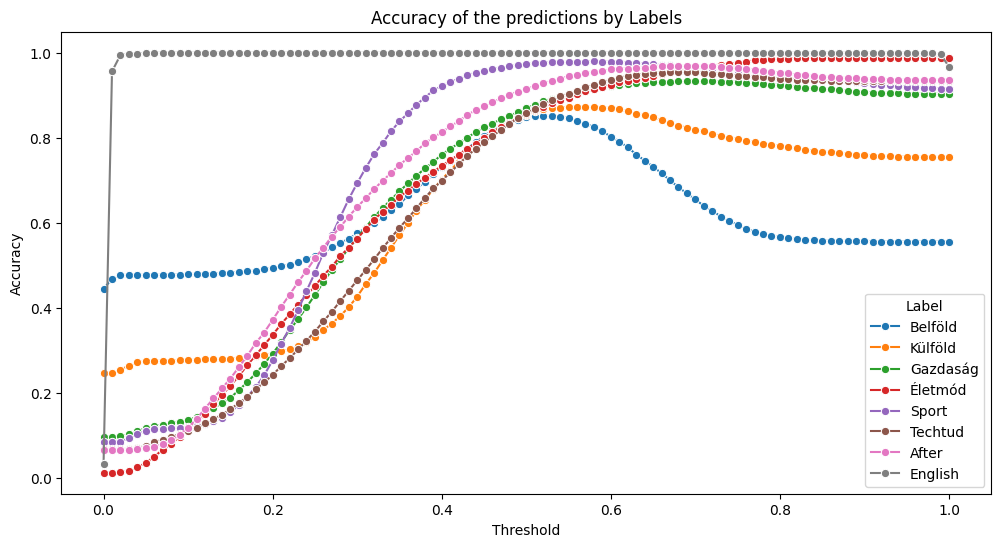

In [8]:
# Plotting Accuracy
plt.figure(figsize = (12, 6))
sns.lineplot(data=evaluation_df, x = 'Threshold', y = 'Accuracy', hue = 'Label', marker = 'o')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy of the predictions by Labels')
plt.legend(title='Label')
plt.show()

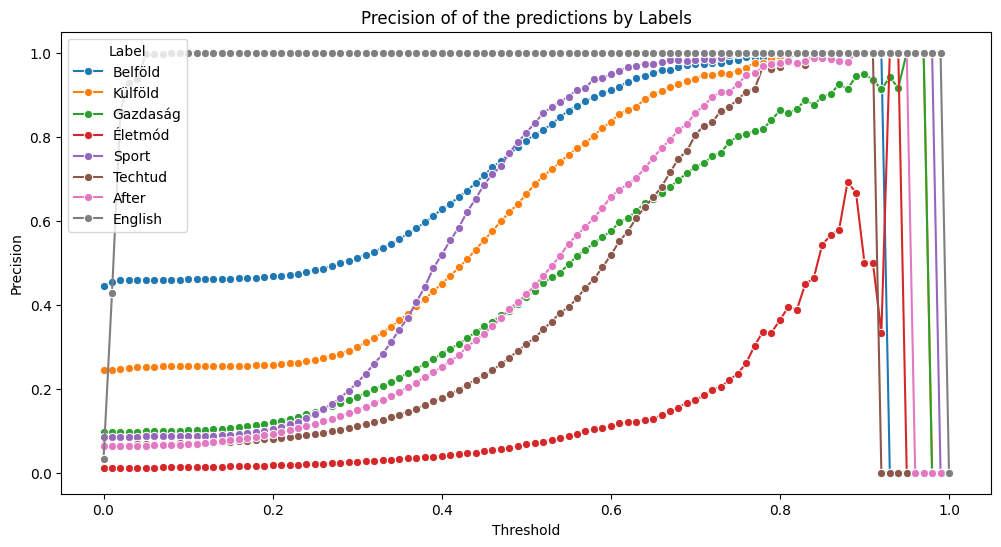

In [9]:
# Plotting Recall
plt.figure(figsize = (12, 6))
sns.lineplot(data=evaluation_df, x = 'Threshold', y = 'Precision', hue = 'Label', marker = 'o')

plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision of of the predictions by Labels')
plt.legend(title='Label')
plt.show()

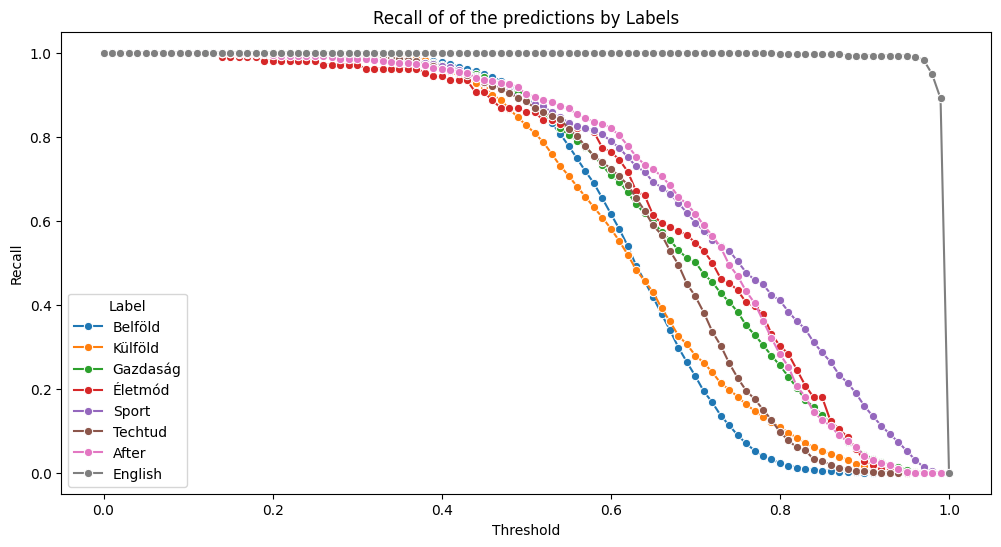

In [10]:
# Plotting Recall
plt.figure(figsize = (12, 6))
sns.lineplot(data=evaluation_df, x = 'Threshold', y = 'Recall', hue = 'Label', marker = 'o')

plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall of of the predictions by Labels')
plt.legend(title='Label')
plt.show()

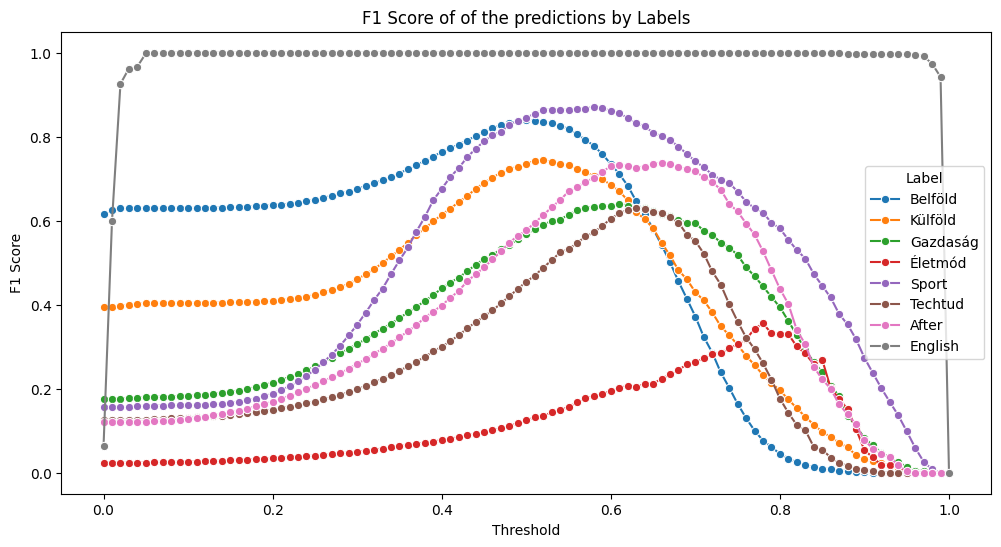

In [11]:
# Plotting F1 Scores
plt.figure(figsize = (12, 6))
sns.lineplot(data=evaluation_df, x = 'Threshold', y = 'F1 Score', hue = 'Label', marker = 'o')

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score of of the predictions by Labels')
plt.legend(title='Label')
plt.show()

#### I choose F1 Score to be the main performance indicator of the models. This score takes on its maximum value on different threshold levels across different labels. Therefore, in the test phase, I set different threshold levels accordingly.

In [12]:
idx = evaluation_df.groupby('Label')['F1 Score'].idxmax()

# Extract the rows with the highest performance values
result = evaluation_df.loc[idx].reset_index(drop=True)

result

,Label,Accuracy,Precision,Recall,F1 Score,Threshold
0,After,0.967680,0.772901,0.705575,0.737705,0.66
1,Belföld,0.847829,0.790968,0.893660,0.839184,0.50
2,English,1.000000,1.000000,1.000000,1.000000,0.08
3,Gazdaság,0.924924,0.595808,0.693380,0.640902,0.61
4,Külföld,0.867131,0.705569,0.787477,0.744276,0.52
5,Sport,0.979800,0.937213,0.814913,0.871795,0.58
6,Techtud,0.948266,0.606202,0.653846,0.629123,0.63
7,Életmód,0.983728,0.336134,0.377358,0.355556,0.78


In [13]:
# Predict probabilities for the validation set
prob_predictions = {}
for label, model in models_log.items():
    prob_predictions[label] = model.predict_proba(features_test)[:, 1]  # Get probabilities for the positive class

# Convert the predictions dictionary to a DataFrame
prob_predictions_df = pd.DataFrame(prob_predictions, index=features_test.index)

# Adjusting the probability threshold
threshold = [0.50, 0.52, 0.61, 0.78, 0.58, 0.63, 0.66, 0.08]
threshold_place = 0
# I Convert probabilities to binary predictions
binary_predictions = pd.DataFrame()
for label in labels.columns:
    binary_predictions[label] = np.where(prob_predictions_df[label] >= threshold[threshold_place], 1, 0)
    threshold_place += 1

# Ensure the indices of binary_predictions match features_test
binary_predictions.index = features_test.index


#### To evaluate the model, I print the performance by label.
#### Predicting 'English' articles massively overperform every other lables. The reason behind that is that vectorizers use the semantic content of a text to produce a vector. These vectorizers are trained for particular languages, therefore applying the same vectorizer on different language texts produce very distinct vectors. As a result, the created vectors are much less meaningful for 'English' texts. But at the same time, the difference between the languages is obvious. This way, the semantic vector of 'English' texts are not meaningful, but they are efficient in predicting the label.

In [14]:
# Evaluating the performance of the Logit model by labels
evaluation_results = []
for label in labels_test.columns:
    accuracy = accuracy_score(labels_test[label], binary_predictions[label])
    precision = precision_score(labels_test[label], binary_predictions[label])
    recall = recall_score(labels_test[label], binary_predictions[label])
    f1 = f1_score(labels_test[label], binary_predictions[label])
    evaluation_results.append({
        'Label': label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

evaluation_df = pd.DataFrame(evaluation_results)

evaluation_df

,Label,Accuracy,Precision,Recall,F1 Score
0,Belföld,0.841674,0.788165,0.888861,0.835490
1,Külföld,0.866360,0.701987,0.782649,0.740127
2,Gazdaság,0.919771,0.585586,0.660271,0.620690
3,Életmód,0.984964,0.311321,0.351064,0.330000
4,Sport,0.981373,0.953632,0.819389,0.881429
5,Techtud,0.946589,0.556619,0.638026,0.594549
6,After,0.968694,0.795918,0.685413,0.736544
7,English,0.999551,0.990000,0.996644,0.993311


#### For those labels that appear frequently in the sample, the model performs relatively well but not for those labels that has much less articles. To see what kind of mistakes the model makes, I construct the confusion matrix.

In [15]:
confusion_matrices = {}
for label in labels_test.columns:
    tn, fp, fn, tp = confusion_matrix(labels_test[label], binary_predictions[label]).ravel()
    confusion_matrices[label] = {
        'True Positive': tp,
        'False Positive': fp,
        'False Negative': fn,
        'True Negative': tn
    }

confusion_df = pd.DataFrame(confusion_matrices).T


confusion_df

,True Positive,False Positive,False Negative,True Negative
Belföld,3583,963,448,3918
Külföld,1696,720,471,6025
Gazdaság,585,414,301,7612
Életmód,33,73,61,8745
Sport,617,30,136,8129
Techtud,349,278,198,8087
After,390,100,179,8243
English,297,3,1,8611


In [16]:
# Is it possible that 'Életmód' articles are very similar to other articles? No.
frequency_table = pd.crosstab(data['Életmód'], data['Belföld'], rownames=['Életmód'], colnames=['Belföld'])
frequency_table

Belföld,0,1
Életmód,,
0,14456,11847
1,277,21


#### Finally, to measure the model performance with a single number, I compute the weighted average of the F1 Score (the harmonic mean of precision and recall). I will use this score to compare all the models. I was considering excluding 'English' articles from the evaluation as they form a completely different category. But finally, I included them as well as they also need to be categorized even if the corresponding semantic vectors are not meaningful. Also they do not change the results much, because every model efficiently predict 'English' labels.

In [17]:
merged_df_logit = pd.merge(evaluation_df, relative_freq, on = 'Label')
# merged_df_logit = merged_df_logit[merged_df_logit['Label'] != 'English']

# Normalize the weights to sum to 1
total_weight = merged_df_logit['relative_frequency'].sum()
merged_df_logit['weight_norm'] = merged_df_logit['relative_frequency'] / total_weight

# Calculating the weighted average of F1 Scores of the labels
f1_logit = (merged_df_logit['F1 Score'] * merged_df_logit['weight_norm']).sum()

f1_logit

0.7759104882946927

### 2. Predicting labels with Bagging

#### In this model, I create various samples, using bootstrapping. Then, I fit the same decision tree model on these samples. Since the samples are somewhat different, the models built up on them might predict labels differently. These rather simple models capture a different aspect of the classification problem due to the bootsrtapped sampling. Condorcet's Jury Theorem suggests that in this case, the majority vote should be better that any single model.

In [18]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.5, random_state=0)

In [19]:
# I create a list for the models that explain the labels
models_bagging = {}

# Training a Bagging model for each label
for label in labels_train.columns:
    # Creating Bagging classification with a decision tree classifier
    bagging = BaggingClassifier(
        estimator = DecisionTreeClassifier(random_state = 0, max_features = None, max_depth = 30), 
        # I was considering 'max_depth' to set lower but it turned out to perform much worse.
        n_estimators = 25,
        random_state = 0
    )
    
    # Fitting the model on the training data
    bagging.fit(features_train, labels_train[label])
    
    # Storing the trained model in the list
    models_bagging[label] = bagging

# Predicting the labels for the test set
predictions = {}
for label, model in models_bagging.items():
    # Predict probabilities
    predictions[label] = model.predict(features_test)
    
predictions_bagging = pd.DataFrame(predictions, index=features_test.index)

#### To evaluate the model, I print the performance by label.

In [20]:
# Evaluating the performance of the models
evaluation_results_bagging = []
for label in labels_test.columns:
    accuracy = accuracy_score(labels_test[label], predictions_bagging[label])
    precision = precision_score(labels_test[label], predictions_bagging[label])
    recall = recall_score(labels_test[label], predictions_bagging[label])
    f1 = f1_score(labels_test[label], predictions_bagging[label])
    evaluation_results_bagging.append({
        'Label': label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

evaluation_df_bagging = pd.DataFrame(evaluation_results_bagging)

evaluation_df_bagging

,Label,Accuracy,Precision,Recall,F1 Score
0,Belföld,0.851214,0.841751,0.821501,0.831503
1,Külföld,0.889181,0.838574,0.675000,0.747948
2,Gazdaság,0.938275,0.812265,0.491667,0.612553
3,Életmód,0.989850,0.827586,0.155844,0.262295
4,Sport,0.975791,0.965363,0.748052,0.842927
5,Techtud,0.956319,0.894428,0.358824,0.512175
6,After,0.970077,0.897887,0.600000,0.719323
7,English,0.999850,1.000000,0.995546,0.997768


In [21]:
confusion_matrices = {}
for label in labels_test.columns:
    tn, fp, fn, tp = confusion_matrix(labels_test[label], predictions_bagging[label]).ravel()
    confusion_matrices[label] = {
        'True Positive': tp,
        'False Positive': fp,
        'False Negative': fn,
        'True Negative': tn
    }

confusion_df = pd.DataFrame(confusion_matrices).T

confusion_df

,True Positive,False Positive,False Negative,True Negative
Belföld,4883,918,1061,6439
Külföld,2187,421,1053,9640
Gazdaság,649,150,671,11831
Életmód,24,5,130,13142
Sport,864,31,291,12115
Techtud,305,36,545,12415
After,510,58,340,12393
English,447,0,2,12852


In [22]:
merged_df_bagging = pd.merge(evaluation_df_bagging, relative_freq, on = 'Label')
merged_df_bagging = merged_df_bagging[merged_df_bagging['Label'] != 'English']

# Normalize the weights to sum to 1
total_weight = merged_df_bagging['relative_frequency'].sum()
merged_df_bagging['weight_norm'] = merged_df_bagging['relative_frequency'] / total_weight

# Calculate the weighted average
f1_bagging = (merged_df_bagging['F1 Score'] * merged_df_bagging['weight_norm']).sum()

# Calculating the F1 score based on the relative weights of the 
f1_bagging

0.7577530731923005

### 3. Predicting labels with Random Forest

#### Random Forest models also make use of bootstrap sampling. The main advantage of them is that Random Forests build models based on only a limited number of randomly selected features. For the selected sample, the model also selects some variables that the model is built up on. Since this introduces more randomness, the resulting models are less correlated, making them efficient tools in classification problems.

In [23]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.5, random_state=0)

#### The procedure is similar to the previous ones: I build separate models for each binary variable. These models predict labels considering exclusively the semantic vectors of the articles. 

In [24]:
# Initialize a dictionary to store models
models_rf = {}
# I create a list for the thresholds for the best f1 scores
best_thresholds_rf = {}

# Train a Random Forest model for each label
for label in labels_train.columns:
    # Create a Random Forest classifier
    rf = RandomForestClassifier(n_estimators = 750, random_state = 0, max_features = 30)
    
    # Fit the model on the training data
    rf.fit(features_train, labels_train[label])
    
    # Store the trained model in the dictionary
    models_rf[label] = rf

# Predict the labels for the test set
predictions = {}
for label, model in models_rf.items():
    predictions[label] = model.predict(features_test)

    # # Apply the best threshold
    # predictions[label] = (probas >= best_thresholds_rf[label]).astype(int)

# Convert predictions dictionary to DataFrame for better visualization
predictions_rf = pd.DataFrame(predictions, index = features_test.index)

In [25]:
# Adding the predicted labels to the test dataframe
predicted_labels = features_test.copy()
for label in predictions_rf.columns:
    predicted_labels[label + '_pred'] = predictions_rf[label]

# Display predicted_labels DataFrame
predicted_labels[0:5]

,new_var_1,new_var_2,new_var_3,new_var_4,new_var_5,new_var_6,new_var_7,new_var_8,new_var_9,new_var_10,...,new_var_299,new_var_300,Belföld_pred,Külföld_pred,Gazdaság_pred,Életmód_pred,Sport_pred,Techtud_pred,After_pred,English_pred
23077,-0.003416,-0.002961,0.052727,-0.004028,-0.004687,-0.005697,0.022260,-0.003910,-0.016467,0.017515,...,0.000310,-0.011310,0,0,0,0,1,0,0,0
6084,-0.016763,-0.007489,0.039228,-0.018113,0.002907,-0.022494,0.029421,-0.004582,-0.017896,0.018745,...,0.007080,0.005128,1,0,0,0,0,0,0,0
5740,-0.008457,0.000578,0.050165,-0.003412,-0.005295,-0.014402,0.015005,-0.005042,-0.007104,0.010288,...,0.005138,0.003436,1,0,0,0,0,0,0,0
22182,-0.002719,-0.008444,0.045496,-0.007340,-0.006093,-0.005989,0.021613,-0.002527,-0.012311,0.012807,...,0.007145,0.002807,0,1,0,0,0,0,0,0
2638,-0.009882,0.012648,0.022581,0.012771,-0.007086,-0.009122,0.013277,0.005827,-0.015667,0.015667,...,-0.003882,0.010435,1,0,0,0,0,0,0,0


#### Again, I construct the evaluation datframe by labels, then, I display the confusion matrix.

In [26]:
# Evaluate the performance of the models
evaluation_results_rf = []
for label in labels_test.columns:
    accuracy = accuracy_score(labels_test[label], predictions_rf[label])
    precision = precision_score(labels_test[label], predictions_rf[label])
    recall = recall_score(labels_test[label], predictions_rf[label])
    f1 = f1_score(labels_test[label], predictions_rf[label])
    evaluation_results_rf.append({
        'Label': label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

evaluation_df_rf = pd.DataFrame(evaluation_results_rf)

evaluation_df_rf

,Label,Accuracy,Precision,Recall,F1 Score
0,Belföld,0.886174,0.882821,0.859354,0.870929
1,Külföld,0.893692,0.910153,0.625309,0.741310
2,Gazdaság,0.937899,0.869760,0.440152,0.584507
3,Életmód,0.990001,0.888889,0.155844,0.265193
4,Sport,0.975566,0.994048,0.722944,0.837093
5,Techtud,0.953312,0.967347,0.278824,0.432877
6,After,0.968875,0.957983,0.536471,0.687783
7,English,0.999850,1.000000,0.995546,0.997768


In [27]:
confusion_matrices = {}
for label in labels_test.columns:
    tn, fp, fn, tp = confusion_matrix(labels_test[label], predictions_rf[label]).ravel()
    confusion_matrices[label] = {
        'True Positive': tp,
        'False Positive': fp,
        'False Negative': fn,
        'True Negative': tn
    }

confusion_df = pd.DataFrame(confusion_matrices).T

confusion_df

,True Positive,False Positive,False Negative,True Negative
Belföld,5108,678,836,6679
Külföld,2026,200,1214,9861
Gazdaság,581,87,739,11894
Életmód,24,3,130,13144
Sport,835,5,320,12141
Techtud,237,8,613,12443
After,456,20,394,12431
English,447,0,2,12852


#### The main performance indicator of the model, namely the weigthed average F1 Score is computed.

In [28]:
merged_df_logit = pd.merge(evaluation_df_rf, relative_freq, on = 'Label')
merged_df_logit = merged_df_logit[merged_df_logit['Label'] != 'English']

# Normalize the weights to sum to 1
total_weight = merged_df_logit['relative_frequency'].sum()
merged_df_logit['weight_norm'] = merged_df_logit['relative_frequency'] / total_weight

# Calculate the weighted average
f1_rf = (merged_df_logit['F1 Score'] * merged_df_logit['weight_norm']).sum()

# Calculating the F1 score based on the relative weights
f1_rf

0.7633794692717832

### 4. Predicting labels with Gradient Boosting Trees

#### Finally, a fourth model is constructed to predict article labels. I use XGBoost from the gradient boosting framework. The weak learners are decision trees. This is a sequentially constructed model, which means that after constructing and evaluating a model, it practically learns from its previous mistakes by assigning extra weights to the misclassified observations. As a result, the model gets better after each iteration.

In [29]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.5, random_state=0)

In [30]:
# Converting datastet structures
dtrain = xgb.DMatrix(features_train, label = labels_train)
dtest = xgb.DMatrix(features_test, label = labels_test)

# Define parameters for multi-label classification
models = []
for i in range(labels.shape[1]):
    # Convert DataFrame to DMatrix
    dtrain = xgb.DMatrix(features_train, label = labels_train.iloc[:, i])
    dtest = xgb.DMatrix(features_test, label = labels_test.iloc[:, i])
    
    # Defining the parameters
    params = {
        'objective': 'binary:logistic',  # Defining the tasjk as a binary classification problem
        'eval_metric': 'logloss',  # Evaluation - objective function
        'max_depth': 5,
        'eta': 0.11,  # Learning speed of the model
        'subsample': 0.8,  # Training subsample size
        'colsample_bytree': 0.17  # Feature subsample size
    }
    
    num_rounds = 500  # Number of boosting rounds
    bst = xgb.train(params, dtrain, num_rounds)
    models.append(bst)

# Predictions
predictions_gb = np.zeros_like(labels_test)
for i, model in enumerate(models):
    predictions_gb[:, i] = np.round(model.predict(dtest))

In [31]:
# Evaluate the performance of the models
evaluation_results_gb = []
for i, label in enumerate(labels_test.columns):
    accuracy = accuracy_score(labels_test[label], predictions_gb[:, i])
    precision = precision_score(labels_test[label], predictions_gb[:, i])
    recall = recall_score(labels_test[label], predictions_gb[:, i])
    f1 = f1_score(labels_test[label], predictions_gb[:, i])
    evaluation_results_gb.append({
        'Label': label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

evaluation_df_gb = pd.DataFrame(evaluation_results_gb)

evaluation_df_gb

,Label,Accuracy,Precision,Recall,F1 Score
0,Belföld,0.895121,0.881052,0.884758,0.882901
1,Külföld,0.928351,0.880786,0.816358,0.847349
2,Gazdaság,0.947372,0.796935,0.630303,0.703892
3,Életmód,0.992407,0.835443,0.428571,0.566524
4,Sport,0.987595,0.969639,0.884848,0.925306
5,Techtud,0.972183,0.900000,0.635294,0.744828
6,After,0.978423,0.924585,0.721176,0.810311
7,English,0.999925,1.000000,0.997773,0.998885


In [32]:
# Generate confusion matrices
confusion_matrices_gb = {}
for i, label in enumerate(labels_test.columns):
    tn, fp, fn, tp = confusion_matrix(labels_test[label], predictions_gb[:, i]).ravel()
    confusion_matrices_gb[label] = {
        'True Positive': tp,
        'False Positive': fp,
        'False Negative': fn,
        'True Negative': tn
    }

confusion_df_gb = pd.DataFrame(confusion_matrices_gb).T

confusion_df_gb

,True Positive,False Positive,False Negative,True Negative
Belföld,5259,710,685,6647
Külföld,2645,358,595,9703
Gazdaság,832,212,488,11769
Életmód,66,13,88,13134
Sport,1022,32,133,12114
Techtud,540,60,310,12391
After,613,50,237,12401
English,448,0,1,12852


In [33]:
merged_df_logit = pd.merge(evaluation_df_gb, relative_freq, on = 'Label')
merged_df_logit = merged_df_logit[merged_df_logit['Label'] != 'English']

# Normalize the weights to sum to 1
total_weight = merged_df_logit['relative_frequency'].sum()
merged_df_logit['weight_norm'] = merged_df_logit['relative_frequency'] / total_weight

# Calculate the weighted average
f1_gb = (merged_df_logit['F1 Score'] * merged_df_logit['weight_norm']).sum()

# Calculating the F1 score based on the relative weights of the 
f1_gb

0.8439050286373199

# Comparing the performances of the 4 models

#### Out of the 4 models, the Gradient Boosting model performed the best on the basis of F1 Score.

In [34]:
print('Weighted average F1 Score of the Logit model: ', f1_logit)
print('Weighted average F1 Score of the Bagging model: ', f1_bagging)
print('Weighted average F1 Score of the Random Forest model: ', f1_rf)
print('Weighted average F1 Score of the Gradient Boosting model: ', f1_gb)


Weighted average F1 Score of the Logit model:  0.7759104882946927
Weighted average F1 Score of the Bagging model:  0.7577530731923005
Weighted average F1 Score of the Random Forest model:  0.7633794692717832
Weighted average F1 Score of the Gradient Boosting model:  0.8439050286373199


#### Feature importance analysis

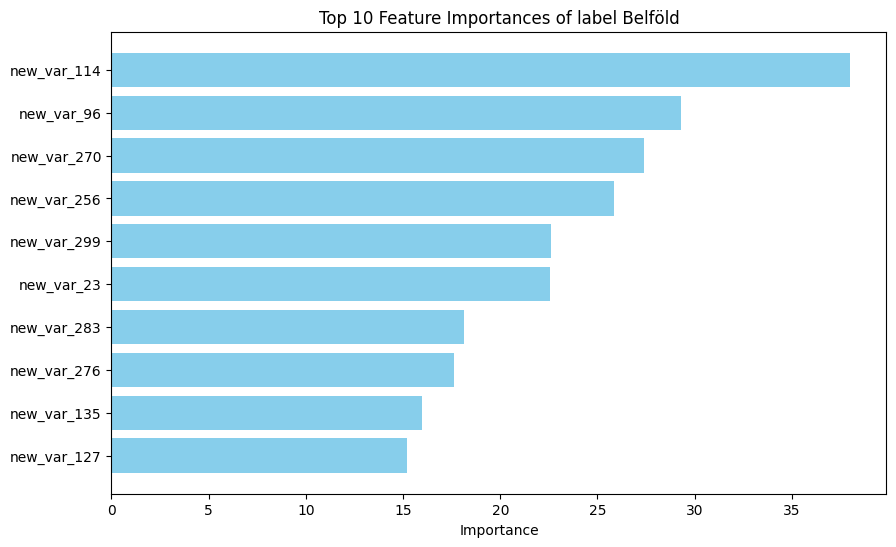

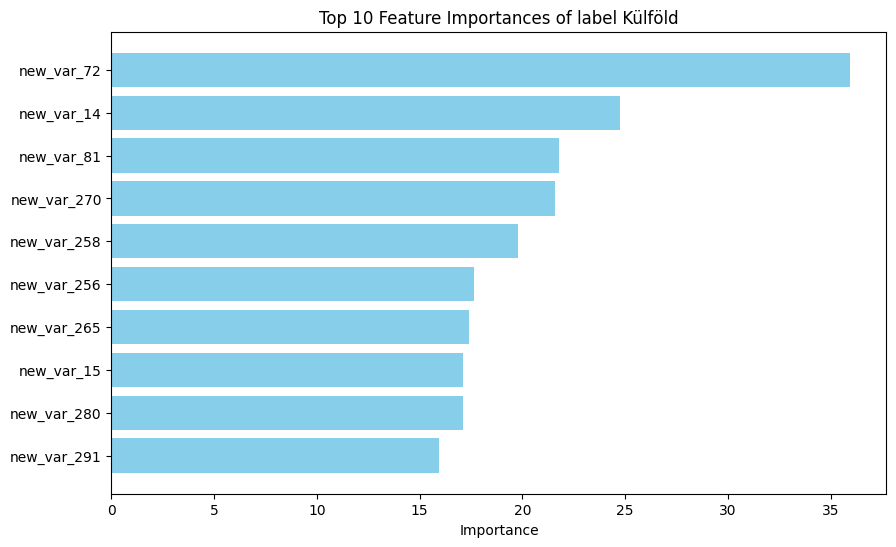

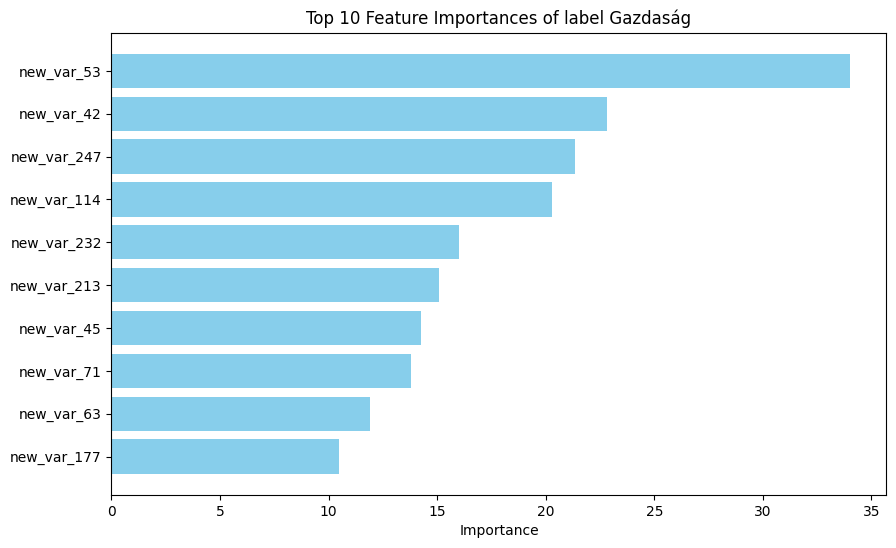

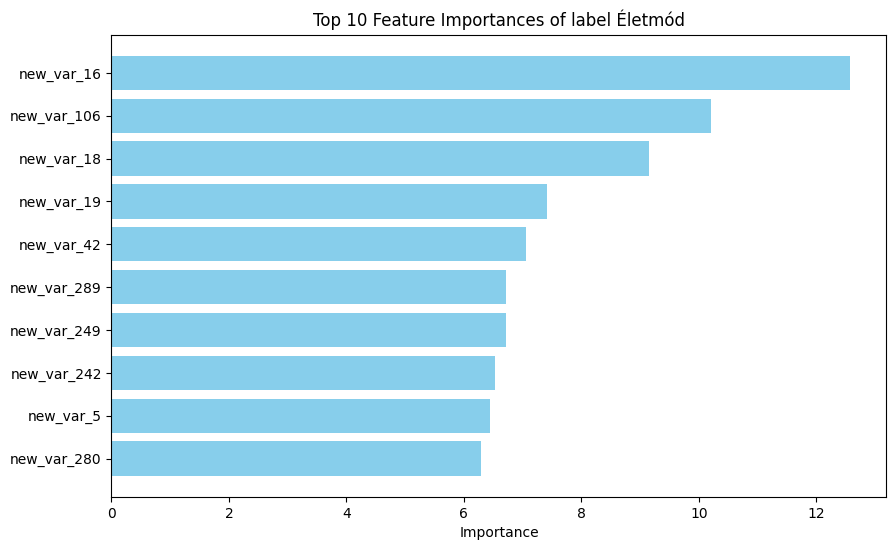

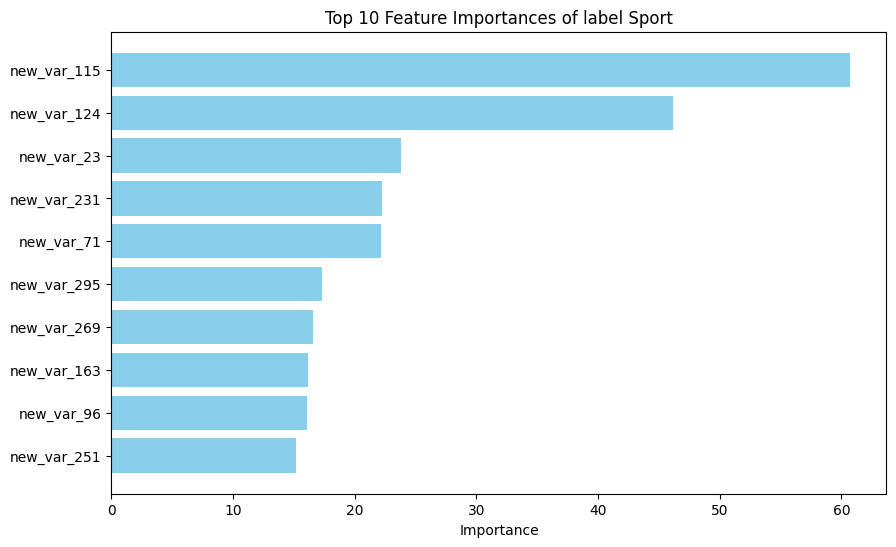

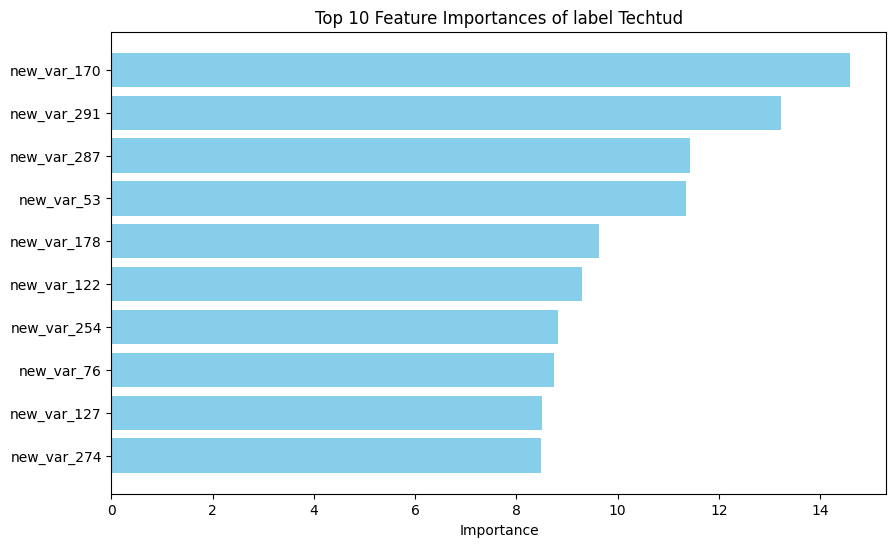

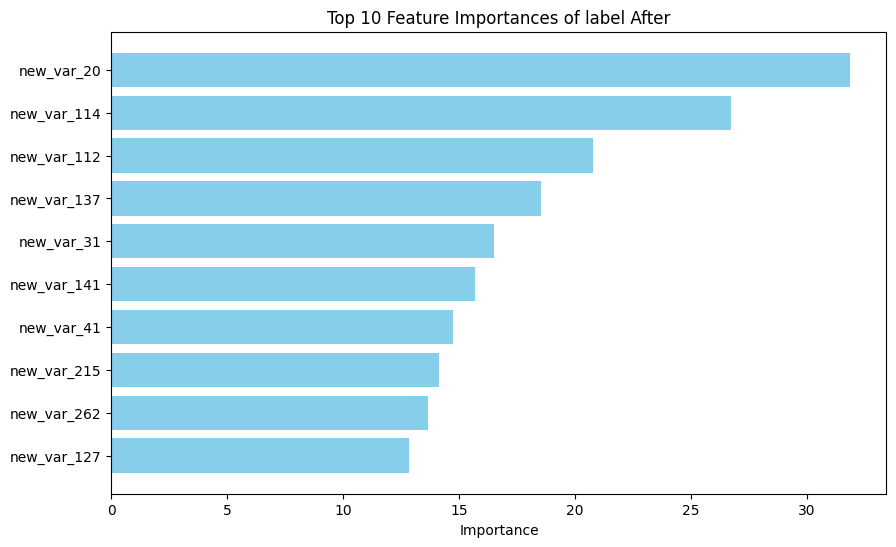

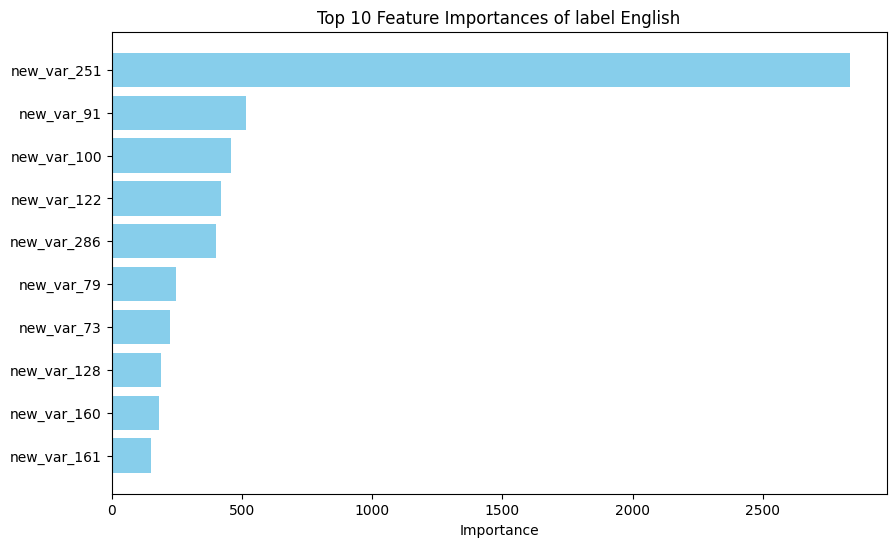

In [35]:
label_titles = ['Belföld', 'Külföld', 'Gazdaság', 'Életmód', 'Sport', 'Techtud', 'After', 'English']
temp = 0
for i in models:
    # Get feature importance scores
    importance_scores = i.get_score(importance_type='gain')

    importance_df = pd.DataFrame(list(importance_scores.items()), columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Selecting top 10 features
    top_k = 10
    top_features = importance_df.head(top_k)

    # Plotting top k features
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Top {top_k} Feature Importances of label {label_titles[temp]}')
    temp +=1
    plt.gca().invert_yaxis()
    plt.show()